## TODO

https://www.kaggle.com/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning

https://arxiv.org/pdf/2006.05987.pdf

https://arxiv.org/pdf/2006.04884.pdf

Abstract

Тонкая настройка предварительно обученных языковых моделей на основе трансформаторов, таких как BERT, стала обычной практикой, доминирующей в списках лидеров в различных тестах NLP. Несмотря на высокие эмпирические характеристики отлаженных моделей, тонкая настройка - это нестабильный процесс: обучение одной и той же модели с несколькими случайными начальными числами может привести к большим отклонениям в производительности задачи. Предыдущая литература (Devlin et al., 2019; Lee et al., 2020; Dodge et al., 2020) идентифицировала две потенциальные причины наблюдаемой нестабильности: катастрофическое забывание и небольшой размер наборов данных для точной настройки. В этой статье мы показываем, что обе гипотезы не могут объяснить неустойчивость тонкой настройки. Мы анализируем BERT, RoBERTa и ALBERT, точно настроенные на трех часто используемых наборах данных из теста GLUE, и показываем, что наблюдаемая нестабильность вызвана трудностями оптимизации, которые приводят к исчезающим градиентам. Кроме того, мы показываем, что оставшаяся дисперсия производительности последующих задач может быть отнесена на счет различий в обобщении, когда точно настроенные модели с потерями при обучении samw демонстрируют заметно разную производительность тестов. Основываясь на нашем анализе, мы представляем простую, но надежную основу, которая делает точную настройку моделей на основе BERT значительно более стабильными, чем предложенные ранее подходы.

FINE-TUNING

we fine-tune uncased BERTLARGE (henceforth BERT) using:
- batch size of 16
- learning rate of 2e−5.

The learning rate is linearly increased from 0 to 2e−5 for the first 10% of iterations—which is known as a warmup—and linearly decreased to 0 afterward.
We apply dropout with probability p = 0.1 and weight decay with λ = 0.01. We train for 3 epochs on all datasets and use global gradient clipping. Following Devlin et al. (2019), we use the AdamW optimizer
(Loshchilov and Hutter, 2019) without bias correction

Отметим, что по сравнению с BERT и RoBERTa, и ALBERT имеют немного другие гиперпараметры. В частности, RoBERTa использует спад веса с λ = 0,1 и без
отсечение градиента, и ALBERT не использует выпадение. 


In [1]:
from IPython.display import clear_output, Image
!pip install transformers
clear_output()

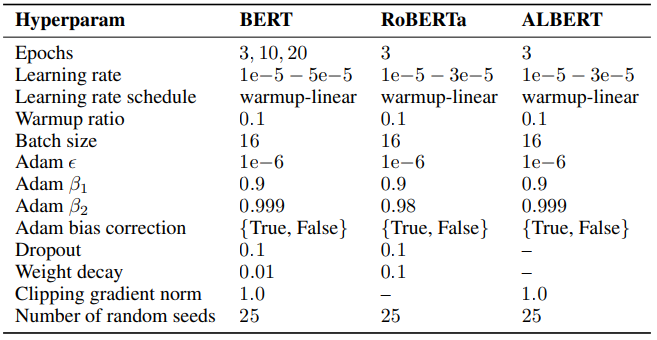

In [ ]:
Image(filename = '/content/drive/MyDrive/CommonLit/plot/tab3.PNG')

In [2]:
import re
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn, optim
import transformers

path_tr = '/content/drive/MyDrive/CommonLit/input/train.csv'
path_test = '/content/drive/MyDrive/CommonLit/input/test.csv'
path_sub = '/content/drive/MyDrive/CommonLit/input/sample_submission.csv'

SEED =13
np.random.seed(SEED)
torch.manual_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = transformers.AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path='roberta-base')
model_config = transformers.AutoConfig.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    num_labels=1)
model = transformers.AutoModel.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    config=model_config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df = pd.read_csv(path_tr)

In [ ]:
txt = df.excerpt[:6].values
tkzr = tokenizer.batch_encode_plus(
    list(txt), # batch_text_or_text_pairs has to be a list (got <class 'numpy.ndarray'>)
    truncation=True,
    max_length=256,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)          

In [ ]:
out = model(**tkzr)
out

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[-0.0676,  0.0801,  0.0089,  ..., -0.0234, -0.0443, -0.0295],
                                                        [-0.0136,  0.2424, -0.1040,  ..., -0.4047,  0.0952, -0.0992],
                                                        [ 0.0357, -0.0299,  0.1018,  ..., -0.2944,  0.0626, -0.1154],
                                                        ...,
                                                        [ 0.0610, -0.0185,  0.1139,  ...,  0.2247,  0.1071,  0.0041],
                                                        [ 0.0610, -0.0185,  0.1139,  ...,  0.2247,  0.1071,  0.0041],
                                                        [ 0.0610, -0.0185,  0.1139,  ...,  0.2247,  0.1071,  0.0041]],
                                               
                                                       [[-0.0829,  0.1356,  0.0139,  ..., -0.0217, -0.0603, -0.049

## Debiasing Omission In BERTAdam
Он отличается от исходного алгоритма ADAM (Kingma & Ba, 2014) тем, что не содержит шага коррекции смещения.

Модели, обученные с помощью BERTAdam на небольших моделях, приводят к недостаточной подгонке, и для простоты эта коррекция имеет решающее значение для точной настройки Transformer на небольших наборах данных, то есть с менее чем 10 тыс. 

- оптимизатор HuggingFace AdamW по умолчанию установлено значение True_bias. Тем не менее стоит отметить важность этого параметра.

*Без коррекции смещения результаты будут вырожденными, а иногда для небольшого числа выборок точно настроенные модели не могут превзойти случайную базовую линию.*

In [ ]:
lr = 2e-5
epsilon = 1e-6
weight_decay = 0.01
use_bertadam = False # not False return True


no_decay = ["bias", "LayerNorm.weight"]
"""
if not any

['embeddings.word_embeddings.weight',
 'embeddings.position_embeddings.weight',
 'embeddings.token_type_embeddings.weight',
 'encoder.layer.0.attention.self.query.weight', ...]

if any

['embeddings.LayerNorm.weight',
 'embeddings.LayerNorm.bias',
 'encoder.layer.0.attention.self.query.bias', ...]

"""
optimizer_grouped_parameters = [{
    "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
    "weight_decay": weight_decay,
    "lr": lr,
},
{
    "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
    "weight_decay": 0.0,
    "lr": lr,
}]

optimizer = transformers.AdamW(
    optimizer_grouped_parameters,
    lr=lr,
    eps=epsilon,
    correct_bias=not use_bertadam # bias correction step
)
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 2e-05
    weight_decay: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 2e-05
    weight_decay: 0.0
)

## Reinitializing Transformer Layers

Это очень интересный метод, в котором вместо использования предварительно обученных весов для всех слоев мы повторно инициализируем уровни пула и верхние блоки Transformer, используя исходную инициализацию Transformer. Повторная инициализация слоев приводит к уничтожению предварительно обученных знаний для этих конкретных блоков.

Идея мотивирована результатами обучения с передачей компьютерного зрения, когда мы знаем, что нижние предварительно обученные слои изучают более общие функции, в то время как более высокие уровни, расположенные ближе к выходу, больше специализируются на задачах предварительного обучения.

**Существующие методы с использованием Transformer показывают, что использование всей сети не всегда является наиболее эффективным выбором и обычно замедляет обучение и снижает производительность.**

*Реализация различается для различных трансформаторов в зависимости от типа трансформатора (автокодирование, авторегрессия и т. Д.).*

###Pooler Reinitialization 

check param model

In [ ]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [ ]:
model.pooler.dense.weight.data

tensor([[ 0.0304,  0.0012, -0.0353,  ...,  0.0271, -0.0321, -0.0027],
        [ 0.0132, -0.0215, -0.0190,  ...,  0.0055, -0.0192,  0.0020],
        [-0.0307, -0.0110,  0.0242,  ...,  0.0262,  0.0125,  0.0163],
        ...,
        [ 0.0364, -0.0208,  0.0136,  ...,  0.0046,  0.0242,  0.0062],
        [ 0.0201, -0.0155,  0.0067,  ...,  0.0232,  0.0241,  0.0100],
        [ 0.0009,  0.0098,  0.0168,  ..., -0.0159, -0.0081, -0.0006]])

In [ ]:
print('Reinitializing Pooler Layer ...')
model.pooler.dense.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
model.pooler.dense.bias.data.zero_()
for p in model.pooler.parameters():
    p.requires_grad = True
print('Done.!')

Reinitializing Pooler Layer ...
Done.!


### Layer Reinitialization - RoBERTa

RoBERTa основывается на BERT и изменяет ключевые гиперпараметры, удаляя цель предварительного обучения в следующем предложении и обучая гораздо более крупными мини-пакетами и скоростями обучения.

In [ ]:
reinit_layers = 2
if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')

    for layer in model.encoder.layer[-reinit_layers:]:
        for module in layer.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
    print('Done.!')

In [ ]:
model.encoder.layer[-2:]

ModuleList(
  (0): RobertaLayer(
    (attention): RobertaAttention(
      (self): RobertaSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): RobertaSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): RobertaIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
    )
    (output): RobertaOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (1): RobertaLayer(
    (attention): Robert

In [ ]:
"""
nn.LayerNorm - Один из способов сократить время обучения - нормализовать активность нейронов.
nn.Embedding - 
    Этот модуль часто используется для хранения вложенных слов и их извлечения с помощью индексов.
    Входом в модуль является список индексов, а выходом - соответствующие вложения слов.
"""
for l in model.encoder.layer[-2:]:
    for m in l.modules():
        if isinstance(m, nn.Linear):
            print('linear-->', m)
        elif isinstance(m, nn.Embedding):
            print('embedding-->', m)
        elif isinstance(m, nn.LayerNorm):
            print('norm-->', m)

linear--> Linear(in_features=768, out_features=768, bias=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
norm--> LayerNorm((768,), eps=1e-05, elementwise_affine=True)
linear--> Linear(in_features=768, out_features=3072, bias=True)
linear--> Linear(in_features=3072, out_features=768, bias=True)
norm--> LayerNorm((768,), eps=1e-05, elementwise_affine=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
linear--> Linear(in_features=768, out_features=768, bias=True)
norm--> LayerNorm((768,), eps=1e-05, elementwise_affine=True)
linear--> Linear(in_features=768, out_features=3072, bias=True)
linear--> Linear(in_features=3072, out_features=768, bias=True)
norm--> LayerNorm((768,), eps=1e-05, elementwise_affin

### Layer Reinitialization  XLNet 
- одна из немногих моделей, в которых нет ограничения на длину последовательности.

XLnet - это расширение модели Transformer-XL, предварительно обученной с использованием метода авторегрессии для изучения двунаправленных контекстов.

In [ ]:
if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    for layer in model.transformer.layer[-reinit_layers :]:
        for module in layer.modules():
            if isinstance(module, (nn.Linear, nn.Embedding)):
                module.weight.data.normal_(mean=0.0, std=model.transformer.config.initializer_range)
                if isinstance(module, nn.Linear) and module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
            elif isinstance(module, XLNetRelativeAttention):
                for param in [
                    module.q,
                    module.k,
                    module.v,
                    module.o,
                    module.r,
                    module.r_r_bias,
                    module.r_s_bias,
                    module.r_w_bias,
                    module.seg_embed,
                ]:
                    param.data.normal_(mean=0.0, std=model.transformer.config.initializer_range)
    print('Done.!')

### Layer Reinitialization - BART

In [ ]:
if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    for layer in model.model.decoder.layers[-reinit_layers :]:
        for module in layer.modules():
            model.model._init_weights(module)
    print('Done.!')

### Layer Reinitialization -resume
Эксперименты показывают, что Re-init более устойчив к неблагоприятным случайным начальным значениям. Улучшения видны, когда повторно инициализируется только уровень пула. Повторная инициализация следующих слоев помогает больше.

Однако не рекомендуется повторно инициализировать более 6 верхних слоев в качестве плато производительности и даже уменьшается, поскольку дальнейшая повторная инициализация разрушает предварительно обученные слои с общими важными функциями. Наилучшее количество повторно устанавливаемых слоев варьируется в зависимости от набора данных.

## Utilizing Intermediate Layers(Использование промежуточных слоев)

Это один из лучших методов, который широко изучался с использованием методов зондирования, который показывает, что предварительно обученные функции из промежуточных слоев более переносимы.

В HuggingFace Transformers есть 2 основных выхода и 3, если они настроены; которое мы получаем после ввода input_ids и attention_mask.

- last hidden state(размер пакета, seq Len, скрытый размер), которое представляет собой последовательность скрытых состояний на выходе последнего слоя.
- pooler output (размер пакета, скрытый размер) - Скрытое состояние последнего уровня первого токена последовательности
-all hidden states (n слоев, размер пакета, seq Len, скрытый размер) - скрытые состояния для всех слоев и для всех идентификаторов.


**Как мы обсуждали ранее в разделе повторной инициализации, выходные данные последнего слоя не всегда могут быть лучшим представлением входного текста во время тонкой настройки для последующих задач.**

Для предварительно обученных языковых моделей, в том числе Transformer, наиболее переносимые контекстуализированные представления входного текста, как правило, **возникают на средних уровнях, в то время как верхние уровни специализируются на языковом моделировании**.

Следовательно, однократное использование вывода последнего слоя может ограничить мощность предварительно обученного представления.

### WeightedLayerPooling 
- вложения токенов - это взвешенное среднее их различных представлений скрытых слоев.

In [ ]:
df = pd.read_csv(path_tr)

In [ ]:
txt = df.excerpt[:6].values
tkzr = tokenizer.batch_encode_plus(
    list(txt), # batch_text_or_text_pairs has to be a list (got <class 'numpy.ndarray'>)
    truncation=True,
    max_length=256,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)          

In [ ]:
out = model(**tkzr)
out['last_hidden_state'].shape, out['pooler_output'].shape

(torch.Size([6, 256, 768]), torch.Size([6, 768]))

In [ ]:
"""
После установки для output_hidden_states значения True мы видим,
что теперь мы получаем три разных результата.

У нас есть 13 выходов скрытых слоев, несмотря на 12 скрытых слоев в модели,
потому что мы также получаем выходные данные для слоев встраивания.
"""
model_config.update({'output_hidden_states':True}) 
model = transformers.AutoModel.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    config=model_config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
out = model(**tkzr)
out['last_hidden_state'].shape, out['pooler_output'].shape, len(out['hidden_states'])

(torch.Size([6, 256, 768]), torch.Size([6, 768]), 13)

In [ ]:
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, features):
        ft_all_layers = features['all_layer_embeddings']

        all_layer_embedding = torch.stack(ft_all_layers)
        all_layer_embedding = all_layer_embedding[self.layer_start:, :, :, :]

        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()

        features.update({'token_embeddings': weighted_average})
        return features

In [ ]:
layer_start = 9
num_hidden_layers = model_config.num_hidden_layers
layer_weights=None
"""
add hidden_states to tokinizer
"""
tkzr.update({'all_layer_embeddings':out['hidden_states']})

In [ ]:
# get 13 tuple
hs_all_layers = tkzr['all_layer_embeddings']
# sysck get dim = torch.Size([13, 6, 256, 768])
embedding_all_layers = torch.stack(hs_all_layers)
# get last 4 layer
embedding_all_layers = torch.stack(hs_all_layers)[layer_start:,:, :, :]
"""
Своего рода тензор, который следует рассматривать как параметр модуля.
Параметры - это подклассы Tensor, которые имеют особое свойство при использовании с Module s
- когда они назначаются в качестве атрибутов Module, они автоматически добавляются в список его параметров
и появляются, например, в итераторе parameters ().
nn.Parameter(
    torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
>>
    Parameter containing:
    tensor([1., 1., 1., 1.], requires_grad=True)
)
"""
# layer_w.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).shape
# torch.Size([4, 1, 1, 1])
# .expand for size torch.Size([4, 6, 256, 768])
# get torch.Size([4, 6, 256, 768]) oll weight ones

weight_factor = layer_w.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(embedding_all_layers.size())
"""
embedding_all_layers is torch.Size([4, 6, 256, 768])
.sum
torch.Size([6, 256, 768])

layer_w.sum() get 4
"""
weighted_average = (weight_factor*embedding_all_layers).sum(dim=0) / layer_w.sum()
tkzr.update({'token_embeddings':weighted_average})
weighted_average[:1], weighted_average.shape

(tensor([[[ 0.0026, -0.0011, -0.0166,  ...,  0.0757, -0.0354, -0.0251],
          [-0.0111,  0.4211, -0.1759,  ..., -0.6203,  0.0228, -0.1172],
          [-0.0216, -0.0688,  0.1603,  ..., -0.2902,  0.0884, -0.1073],
          ...,
          [ 0.0313, -0.2598,  0.4431,  ...,  0.7527,  0.4063,  0.0223],
          [ 0.0313, -0.2598,  0.4431,  ...,  0.7527,  0.4063,  0.0223],
          [ 0.0313, -0.2598,  0.4431,  ...,  0.7527,  0.4063,  0.0223]]],
        grad_fn=<SliceBackward>), torch.Size([6, 256, 768]))

Теперь у нас есть комбинированное окончательное представление последних четырех слоев. Теперь мы можем просто взять выходные данные токена cls, объединить. Здесь также можно применить стандартную операцию объединения, реализованную в HuggingFace Transformer для BERT, RoBERTa и т. Д. Ниже мы просто берем выходные данные токена cls и передаем их с линейного слоя.

In [ ]:
sequence_output = tkzr['token_embeddings'][:, 0]
nn.Linear(model_config.hidden_size, 1)(sequence_output)

tensor([[0.7335],
        [0.7271],
        [0.7247],
        [0.7316],
        [0.7296],
        [0.7366]], grad_fn=<AddmmBackward>)

### Pooling Strategy and Layer Choice

Авторы BERT протестировали стратегии встраивания слов, подавая различные комбинации векторов в качестве входных характеристик в BiLSTM, используемый в задаче распознавания именованных сущностей, и наблюдая за полученными баллами F1.

Это частично демонстрируется замечанием, что разные уровни BERT кодируют очень разные виды информации, поэтому соответствующая стратегия объединения будет меняться в зависимости от приложения, поскольку разные уровни кодируют разные виды информации.

<img src = 'http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png'/>

Встраивания начинаются с первого уровня как не имеющие контекстной информации.
По мере того, как вложения углубляются в сеть, они собирают все больше и больше контекстной информации с каждым уровнем.
Однако по мере приближения к последнему уровню вы начинаете собирать информацию, относящуюся к задачам предварительного обучения BERT («Маскированная языковая модель» (MLM) и «Предсказание следующего предложения» (NSP)).

*Нам нужны вложения, которые хорошо кодируют значение слова ...
BERT мотивирован делать это, но он также мотивирован кодировать что-либо еще, что помогло бы ему определить, что такое пропущенное слово (MLM), или появилось ли второе предложение после первого (NSP).*

**Предпоследний слой - это разумная золотая середина.**

## LLRD - Layerwise Learning Rate Decay
послойное снижение скорости обучения

LLRD - это метод, который применяет более высокие скорости обучения для верхних слоев и более низкие скорости обучения для нижних уровней. Это достигается путем установки скорости обучения верхнего уровня и использования скорости мультипликативного затухания для уменьшения скорости обучения слой за слоем сверху вниз.

Цель состоит в том, чтобы изменить нижние уровни, которые кодируют более общую информацию меньше, чем верхние уровни, которые более специфичны для задачи предварительного обучения. Этот метод используется при тонкой настройке нескольких последних предварительно обученных моделей, включая XLNet и ELECTRA.

In [ ]:
# optimizer params
learning_rate = 5e-5
layerwise_learning_rate_decay = 0.9
weight_decay = 0.01
adam_epsilon = 1e-6
use_bertadam = False
# scheduler params
num_epochs = 20
num_warmup_steps = 0

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path='roberta-base')
model_config = transformers.AutoConfig.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    num_labels=1)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    config=model_config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
def get_optimizer_grouped_parameters(
    model, model_type, 
    learning_rate, weight_decay, 
    layerwise_learning_rate_decay
):
    no_decay = ["bias", "LayerNorm.weight"]
    # initialize lr for task specific layer
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if "classifier" in n or "pooler" in n],
            "weight_decay": 0.0,
            "lr": learning_rate,
        },
    ]
    # initialize lrs for every layer
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = learning_rate
    for layer in layers:
        lr *= layerwise_learning_rate_decay
        """
        n - name
        p - weight(values) 
        not any
            'roberta.embeddings.word_embeddings.weight',
            'roberta.encoder.layer.0.attention.self.key.weight',
            'roberta.encoder.layer.0.attention.self.value.weight',  
            ...
        any
            'roberta.embeddings.LayerNorm.weight',
            'roberta.embeddings.LayerNorm.bias',
            'roberta.encoder.layer.0.attention.self.query.bias',
            'roberta.encoder.layer.0.attention.self.key.bias',  
            ...   
        """
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [ ]:
grouped_optimizer_params = get_optimizer_grouped_parameters(
    model,
    'roberta', 
    learning_rate, weight_decay, 
    layerwise_learning_rate_decay
)


optimizer = transformers.AdamW(
    grouped_optimizer_params,
    lr=learning_rate,
    eps=adam_epsilon,
    correct_bias=not use_bertadam
)


scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_epochs
)


optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 5e-05
    lr: 5e-05
    weight_decay: 0.0

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 4.5e-05
    lr: 4.5e-05
    weight_decay: 0.01

Parameter Group 2
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 4.5e-05
    lr: 4.5e-05
    weight_decay: 0.0

Parameter Group 3
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 4.05e-05
    lr: 4.05e-05
    weight_decay: 0.01

Parameter Group 4
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 4.05e-05
    lr: 4.05e-05
    weight_decay: 0.0

Parameter Group 5
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 3.6450000000000005e-05
    lr: 3.6450000000000005e-05
    weight_decay: 0.01

Parameter Group 6
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 3.645

In [ ]:
(learning_rates1, learning_rates2, learning_rates3, learning_rates4,
learning_rates5, learning_rates6, learning_rates7, learning_rates8,
learning_rates9, learning_rates10, learning_rates11, learning_rates12, 
learning_rates13, learning_rates14) = [[] for i in range(14)]

def collect_lr(optimizer):
    learning_rates1.append(optimizer.param_groups[0]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])
    learning_rates3.append(optimizer.param_groups[4]["lr"])
    learning_rates4.append(optimizer.param_groups[6]["lr"])
    learning_rates5.append(optimizer.param_groups[8]["lr"])
    learning_rates6.append(optimizer.param_groups[10]["lr"])
    learning_rates7.append(optimizer.param_groups[12]["lr"])
    learning_rates8.append(optimizer.param_groups[14]["lr"])
    learning_rates9.append(optimizer.param_groups[16]["lr"])
    learning_rates10.append(optimizer.param_groups[18]["lr"])
    learning_rates11.append(optimizer.param_groups[20]["lr"])
    learning_rates12.append(optimizer.param_groups[22]["lr"])
    learning_rates13.append(optimizer.param_groups[24]["lr"])
    learning_rates14.append(optimizer.param_groups[26]["lr"])

collect_lr(optimizer)
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    collect_lr(optimizer)

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
pio.templates.default='plotly_white'

def get_default_layout(title):
    font_style = 'Courier New'
    layout = {}
    #layout['height'] = 400
    #layout['width'] = 1200
    layout['template'] = 'plotly_white'
    layout['dragmode'] = 'zoom'
    layout['hovermode'] = 'x'
    layout['hoverlabel'] = {
        'font_size': 14,
        'font_family':font_style
    }
    layout['font'] = {
        'size':14,
        'family':font_style,
        'color':'rgb(128, 128, 128)'
    }
    layout['xaxis'] = {
        'title': 'Epochs',
        'showgrid': True,
        'type': 'linear',
        'categoryarray': None,
        'gridwidth': 1,
        'ticks': 'outside',
        'showline': True, 
        'showticklabels': True,
        'tickangle': 0,
        'tickmode': 'array'
    }
    layout['yaxis'] = {
        'title': 'Learning Rate',
        'exponentformat':'none',
        'showgrid': True,
        'type': 'linear',
        'categoryarray': None,
        'gridwidth': 1,
        'ticks': 'outside',
        'showline': True, 
        'showticklabels': True,
        'tickangle': 0,
        'tickmode': 'array'
    }
    layout['title'] = {
        'text':title,
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'family':font_style,
            'size':14,
            'color':'black'
        }
    }
    layout['showlegend'] = True
    layout['legend'] = {
        'x':0.1,
        'y':1.1,
        'orientation':'h',
        'itemclick': 'toggleothers',
        'font': {
            'family':font_style,
            'size':14,
            'color':'black'
        }
    }
    return go.Layout(layout)

In [ ]:
def build_trace(learning_rates, num_epochs, name, color):
    return go.Scatter(
        x=list(range(0, num_epochs, 1)), 
        y=learning_rates, 
        texttemplate="%{y:.6f}",
        mode='markers+lines',
        name=name,
        marker=dict(color=color),
    )

trace1 = build_trace(learning_rates1, num_epochs, name='Regressor', color='#83c8d2')
trace2 = build_trace(learning_rates2, num_epochs, name='Layer 12', color='#82c9d2')
trace3 = build_trace(learning_rates3, num_epochs, name='Layer 11', color='#85c7cf')
trace4 = build_trace(learning_rates4, num_epochs, name='Layer 10', color='#88c4cc')
trace5 = build_trace(learning_rates5, num_epochs, name='Layer 9', color='#8cc1c8')
trace6 = build_trace(learning_rates6, num_epochs, name='Layer 8', color='#8fbfc5')
trace7 = build_trace(learning_rates7, num_epochs, name='Layer 7', color='#92bcc2')
trace8 = build_trace(learning_rates8, num_epochs, name='Layer 6', color='#96babe')
trace9 = build_trace(learning_rates9, num_epochs, name='Layer 5', color='#99b7bb')
trace10 = build_trace(learning_rates10, num_epochs, name='Layer 4', color='#9cb4b8')
trace11 = build_trace(learning_rates11, num_epochs, name='Layer 3', color='#a0b2b4')
trace12 = build_trace(learning_rates12, num_epochs, name='Layer 2', color='#a3afb1')
trace13 = build_trace(learning_rates13, num_epochs, name='Layer 1', color='#a7adad')
trace14 = build_trace(learning_rates14, num_epochs, name='Embeddings', color='#aaa')

layout=get_default_layout('Layer Wise Learning Rate Decay')
fig = go.Figure(
    data=[
        trace1, trace2, trace3, trace4, trace5, trace6, 
        trace7, trace8, trace9, trace10, trace11, trace12, 
        trace13, trace14
    ], 
    layout=layout.update({'showlegend':False})
)

fig.show()

## Guide to HuggingFace Schedulers & Differential LRs
[link](https://www.kaggle.com/rhtsingh/guide-to-huggingface-schedulers-differential-lrs)

Differential / Discriminative Learning Rate(
Дифференциальная / дискриминационная скорость обучения)


Интуитивно понятная идея дифференциальной скорости обучения заключается в том, что вложения начинаются с первого уровня и не имеют контекстной информации. По мере того, как вложения углубляются в сеть, они собирают более общую и контекстную информацию с каждым уровнем. Однако по мере того, как мы приближаемся к последним уровням, мы начинаем собирать информацию, относящуюся к задачам предварительного обучения Transformer (например, «Маскированная языковая модель» (MLM) RoBERTa и «Предсказание следующего предложения» (NSP).


Таким образом, мы можем точно настроить слои с разной скоростью обучения, то есть более низкой скоростью обучения на ранних уровнях, немного выше на средних уровнях и выше на верхних уровнях.

Мы также можем обучать слои для конкретных задач с совершенно другой и гораздо более высокой скоростью обучения, чем модель трансформатора, поскольку она не обучалась раньше и должна учиться быстрее.

Стратегии установки скорости обучения:

- Единая скорость обучения для полной модели (моделей) - в этой стратегии мы установим единую скорость обучения (в данном случае - 5e-5) для полной модели, что обычно и делается.
- Дифференциальная скорость обучения для уровня трансформатора и уровня задачи (i) - в этой стратегии у нас будет два разных lr. Один унифицирован для полной модели преобразователя (RoBERTa), а другой - для уровня конкретной задачи (Regressor).
- Дифференциальная скорость обучения для слоев трансформатора и слоя для конкретных задач (a) - здесь мы также установим разные lr для разных слоев трансформатора. Я сгруппировал слои 1-4, 4-8, 8-12 и соответственно установил скорость обучения, как обсуждалось выше. Помимо этого, я также установил другую и более высокую скорость обучения для регрессора.

In [3]:
def get_optimizer_params(model, type='s'):
    # differential learning rate and weight decay
    param_optimizer = list(model.named_parameters())
    learning_rate = 5e-5
    no_decay = ['bias', 'gamma', 'beta']
    if type == 's':
        optimizer_parameters = filter(lambda x: x.requires_grad, model.parameters())
    elif type == 'i':
        optimizer_parameters = [
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0},
            {'params': [p for n, p in model.named_parameters() if "roberta" not in n],
             'lr': 1e-3,
             'weight_decay_rate':0.01}
        ]
    elif type == 'a':
        group1=['layer.0.','layer.1.','layer.2.','layer.3.']
        group2=['layer.4.','layer.5.','layer.6.','layer.7.']    
        group3=['layer.8.','layer.9.','layer.10.','layer.11.']
        group_all=['layer.0.','layer.1.','layer.2.','layer.3.','layer.4.','layer.5.','layer.6.','layer.7.','layer.8.','layer.9.','layer.10.','layer.11.']
        optimizer_parameters = [
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay_rate': 0.01},
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group1)],'weight_decay_rate': 0.01, 'lr': learning_rate/2.6},
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group2)],'weight_decay_rate': 0.01, 'lr': learning_rate},
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group3)],'weight_decay_rate': 0.01, 'lr': learning_rate*2.6},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay_rate': 0.0},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group1)],'weight_decay_rate': 0.0, 'lr': learning_rate/2.6},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group2)],'weight_decay_rate': 0.0, 'lr': learning_rate},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group3)],'weight_decay_rate': 0.0, 'lr': learning_rate*2.6},
            {'params': [p for n, p in model.named_parameters() if "roberta" not in n], 'lr':1e-3, "momentum" : 0.99},
        ]
    return optimizer_parameters

In [10]:
def get_default_layout(title):
    font_style = 'Courier New'
    layout = {}
    layout['height'] = 400
    layout['width'] = 800
    layout['template'] = 'plotly_white'
    layout['dragmode'] = 'zoom'
    layout['hovermode'] = 'x'
    layout['hoverlabel'] = {
        'font_size': 14,
        'font_family':font_style
    }
    layout['font'] = {
        'size':14,
        'family':font_style,
        'color':'rgb(128, 128, 128)'
    }
    layout['xaxis'] = {
        'title': 'Epochs',
        'showgrid': True,
        'type': 'linear',
        'categoryarray': None,
        'gridwidth': 1,
        'ticks': 'outside',
        'showline': True, 
        'showticklabels': True,
        'tickangle': 0,
        'tickmode': 'array'
    }
    layout['yaxis'] = {
        'title': 'Learning Rate',
        'exponentformat':'none',
        'showgrid': True,
        'type': 'linear',
        'categoryarray': None,
        'gridwidth': 1,
        'ticks': 'outside',
        'showline': True, 
        'showticklabels': True,
        'tickangle': 0,
        'tickmode': 'array'
    }
    layout['title'] = {
        'text':title,
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'family':font_style,
            'size':14,
            'color':'black'
        }
    }
    layout['showlegend'] = True
    layout['legend'] = {
        'x':0.1,
        'y':1.1,
        'orientation':'h',
        'itemclick': 'toggleothers',
        'font': {
            'family':font_style,
            'size':14,
            'color':'black'
        }
    }
    return go.Layout(layout)

In [5]:
model_config = transformers.AutoConfig.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    num_labels=1)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='roberta-base',
    config=model_config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [11]:
import plotly
import plotly.graph_objs as go

###Constant Schedule

In [14]:
parameters = get_optimizer_params(model, 's')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
epochs = 10
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_constant_schedule(optimizer)

learning_rates1, learning_rates2 = [[] for i in range(2)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[0]["lr"])


trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Constant Schedule')
go.Figure(data=[trace1, trace2], layout=layout)

In [12]:
parameters = get_optimizer_params(model, 'i')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
epochs = 10
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_constant_schedule(optimizer)

learning_rates1, learning_rates2 = [[] for i in range(2)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[0]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Constant Schedule')
go.Figure(data=[trace1, trace2], layout=layout)

### Constant Schedule with Warmup
Создайте расписание с постоянной скоростью обучения, которому предшествует период разминки, в течение которого скорость обучения линейно увеличивается от 0 до начального значения lr, установленного в оптимизаторе.

In [15]:
parameters = get_optimizer_params(model, 'i')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_constant_schedule_with_warmup(optimizer, num_warmup_steps=3)

learning_rates1, learning_rates2 = [[] for i in range(2)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[0]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Constant Schedule with Warmup')
go.Figure(data=[trace1, trace2], layout=layout)

### Cosine with Warmup

Создайте расписание со скоростью обучения, которая уменьшается в соответствии со значениями функции косинуса между начальным lr, установленным в оптимизаторе до 0, после периода прогрева, в течение которого он увеличивается линейно между 0 и начальным lr, установленным в оптимизаторе.

In [16]:
parameters = get_optimizer_params(model, 'i')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=10)

learning_rates1, learning_rates2 = [[] for i in range(2)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[0]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Cosine Schedule with Warmup')
go.Figure(data=[trace1, trace2], layout=layout)

In [18]:
parameters = get_optimizer_params(model, 'a')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=10)

learning_rates1, learning_rates2, learning_rates3, learning_rates4 = [[] for i in range(4)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[1]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])
    learning_rates3.append(optimizer.param_groups[3]["lr"])
    learning_rates4.append(optimizer.param_groups[8]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 1-4',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 5-8',
    marker=dict(color='#a678de'),
)
trace3 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates3, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 9-12',
    marker=dict(color='#6ad49b'),
)
trace4 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates4, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Cosine Schedule with Warmup')
go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

### Cosine With Hard Restarts

In [20]:
parameters = get_optimizer_params(model, 'a')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=10, num_cycles=5)

learning_rates1, learning_rates2, learning_rates3, learning_rates4 = [[] for i in range(4)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[1]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])
    learning_rates3.append(optimizer.param_groups[3]["lr"])
    learning_rates4.append(optimizer.param_groups[8]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 1-4',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 5-8',
    marker=dict(color='#a678de'),
)
trace3 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates3, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 9-12',
    marker=dict(color='#6ad49b'),
)
trace4 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates4, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Cosine Schedule with Hard Restarts with Warmup')
go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

### Linear Schedule with Warmup

In [22]:
parameters = get_optimizer_params(model, 'a')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=10)

learning_rates1, learning_rates2, learning_rates3, learning_rates4 = [[] for i in range(4)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[1]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])
    learning_rates3.append(optimizer.param_groups[3]["lr"])
    learning_rates4.append(optimizer.param_groups[8]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 1-4',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 5-8',
    marker=dict(color='#a678de'),
)
trace3 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates3, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 9-12',
    marker=dict(color='#6ad49b'),
)
trace4 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates4, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Linear Schedule with Warmup')
go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

### Polynomial Decay with Warmup

In [24]:

parameters = get_optimizer_params(model, 'a')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = transformers.AdamW(parameters, lr=5e-5, **kwargs)
scheduler = transformers.get_polynomial_decay_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=10, power=2)

learning_rates1, learning_rates2, learning_rates3, learning_rates4 = [[] for i in range(4)]
for i in range(epochs):
    optimizer.step()
    scheduler.step()
    learning_rates1.append(optimizer.param_groups[1]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])
    learning_rates3.append(optimizer.param_groups[3]["lr"])
    learning_rates4.append(optimizer.param_groups[8]["lr"])

trace1 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates1, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 1-4',
    marker=dict(color='#3498d5'),
)
trace2 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates2, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 5-8',
    marker=dict(color='#a678de'),
)
trace3 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates3, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Roberta Layers 9-12',
    marker=dict(color='#6ad49b'),
)
trace4 = go.Scatter(
    x=np.arange(0, epochs, 1), 
    y=learning_rates4, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='Regressor',
    marker=dict(color='#f29191'),
)
layout=get_default_layout('Polynomial Decay Schedule with Warmup')
go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

In [ ]:
https://www.kaggle.com/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning